In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

import joblib
from datetime import datetime

"Libraries to help with jupyter notebook usage"
# Increases jupyter notebook display width
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from IPython.display import Image # Helps display images in notebook

In [2]:
import sys
"Appends both parent and grandparent dir to current path, to allow importing"
sys.path.append('..')
sys.path.append('../..')

from jupyternotebook_utils import *
from utils import *
from data_processing import *
from spotify_data import *
from spotify_utils import *

## Data Import
Import files containing information regarding tracks from over 6000 different genres and their audio features, roughly 50 tracks per genre

In [3]:
audio_features_by_genre_file_path = f'../../data/processed_data/genres/audio_features_by_genre.csv'
audio_features_by_genre_df = pd.read_csv(audio_features_by_genre_file_path)
original_audio_features_by_genre_df = audio_features_by_genre_df.copy()

clustered_audio_features_by_genre_file_path = f'../../data/processed_data/genres/clustered_audio_features_by_genre.csv'

## 2. Data Pre-processing
1. Remove irrelevant columns such as key and duration
2. Remove outliers for each audio features in `audio_features_df`
3. Perform One-Hot-Encoding (OHE) for `track_popularity` and `release_date` in `track_details_df`

## Utility for Pre-processing
Declaration of constants and functions to be used for data pre-processing

In [4]:
before_graph_audio_features_df = audio_features_by_genre_df.copy()
after_graph_audio_features_df = audio_features_by_genre_df.copy()

num_bins = 250

graph_height = 4
graph_width = 4

audio_features_list = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 
                       'acousticness', 'instrumentalness', 'liveness', 'valence',
                       'tempo', 'duration_ms']

def plot_graph(plot_title, graph_height, graph_width, graph_features_list = audio_features_list, graph_df = before_graph_audio_features_df):
    graph_height = graph_height
    graph_width = graph_width
    graph_count = len(graph_features_list)

    fig, axes = plt.subplots(1, graph_count, figsize=(graph_width * graph_count, graph_height))
    fig.suptitle(plot_title, fontsize=16)
    
    for i, audio_feature in enumerate(graph_features_list, start = 0):
        ax = axes[i]
        ax.hist(graph_df[audio_feature], bins=num_bins, range=(0, 1), edgecolor='none')
        ax.set_title(f'{str(audio_feature).capitalize()}')
        ax.set_xlabel(f'{audio_feature.capitalize()}')
        ax.set_ylabel('Frequency')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [5]:
before_graph_audio_features_df.describe()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,313696.000000,313696.000000,313696.000000,313696.000000,313696.000000,313696.000000,313696.000000,313696.000000,313696.000000,313696.000000,3.136960e+05
mean,0.555475,0.611720,5.284119,-9.056178,0.089687,0.349921,0.194117,0.193606,0.483863,121.383261,2.339954e+05
std,0.185567,0.263075,3.547774,5.619047,0.110754,0.346926,0.336085,0.161578,0.270005,30.236985,1.333044e+05
min,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000e+03
25%,0.433000,0.434000,2.000000,-10.865000,0.036000,0.022200,0.000000,0.096600,0.258000,97.987750,1.728270e+05
50%,0.571000,0.649000,5.000000,-7.590000,0.048900,0.223000,0.000197,0.127000,0.475000,120.043000,2.141290e+05
75%,0.696000,0.832000,8.000000,-5.459000,0.089700,0.663000,0.216000,0.245000,0.706000,140.031000,2.655202e+05
max,0.988000,1.000000,11.000000,4.791000,0.971000,0.996000,1.000000,1.000000,1.000000,245.941000,5.139749e+06


In [6]:
# Step 1: Min-max normalization for selected features
input_data_ranges = {
    'loudness': (-60, 0),
    'tempo': (0, 250),
    'key': (-1, 11)
}
for feature, (feature_min, feature_max) in input_data_ranges.items():
    after_graph_audio_features_df[feature] = (after_graph_audio_features_df[feature] - feature_min) / (feature_max - feature_min)

# Step 2: Keep selected audio features
selected_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo']
filtered_data = after_graph_audio_features_df[selected_features].copy()

# Step 3: Cube root transformation for selected features
cubed_features = ['speechiness', 'acousticness', 'liveness']
for feature in cubed_features:
    filtered_data[feature] = np.cbrt(filtered_data[feature])

# Step 4: Logarithmic transformation for selected features
log_features = ['energy', 'loudness']
for feature in log_features:
    filtered_data[feature] = np.log1p(filtered_data[feature])

# Step 5: IQR-filtering based on thresholds
lower_thresholds =  {'danceability': 0.16850000000000004, 'energy': 0.14936944969853527, 'loudness': 0.5734535346157168, 
                     'speechiness': 0.11183139278235099, 'acousticness': -0.35285124201451823, 'liveness': 0.20276263879283324, 
                     'valence': -0.24249999999999988, 'tempo': 0.16009000000000007}
upper_thresholds = {'danceability': 1.0525, 'energy': 0.8605850164229211, 'loudness': 0.698995265917933, 
                    'speechiness': 0.6924946680943335, 'acousticness': 1.280417950271011, 'liveness': 0.8754111662234604, 
                    'valence': 1.2494999999999998, 'tempo': 0.7998179999999999}

for feature in selected_features:
    filtered_data[feature] = np.where(
        (filtered_data[feature] >= lower_thresholds[feature]) &
        (filtered_data[feature] <= upper_thresholds[feature]),
        filtered_data[feature],
        np.nan
    )

# Step 6: Min-max Normalization
feature_min = {'danceability': 0.169, 'energy': 0.1501426584297195, 'loudness': 0.5734623376139655, 
               'speechiness': 0.27977873676275317, 'acousticness': 0.0, 'liveness': 0.21074564860592623, 
               'valence': 0.0, 'tempo': 0.164644}

feature_max = {'danceability': 0.991, 'energy': 0.6931471805599453, 'loudness': 0.6983917371326527, 
               'speechiness': 0.692435557262704, 'acousticness': 0.9986648849277057, 'liveness': 0.8750340122833274, 
               'valence': 1.0, 'tempo': 0.799812}

for feature in selected_features:
    if feature in feature_min:
        after_graph_audio_features_df[feature] = (after_graph_audio_features_df[feature] - feature_min[feature]) / (feature_max[feature] - feature_min[feature])

## Genre Clustering Using KMeans Algorithm

Here's an overview of the whole clustering process:
1. Identifying the optimal value of K for the Partitioning Clustering using the Elbow Method.
2. Run Kmeans algorithm using the optimal K value.
3. For each cluster, re-run Elbow Method to find the optimal K value for Hierachial Subclustering.

### Constant Declarations for KMeans Algorithm

In [7]:
from IPython.display import clear_output # clears output for better logging
from sklearn.cluster import KMeans
from collections import Counter # used to count frequency of genres in each cluster

min_clusters = 1
max_clusters = 11

# NOTE: key, and duration_ms is removed
audio_feature_columns = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo']

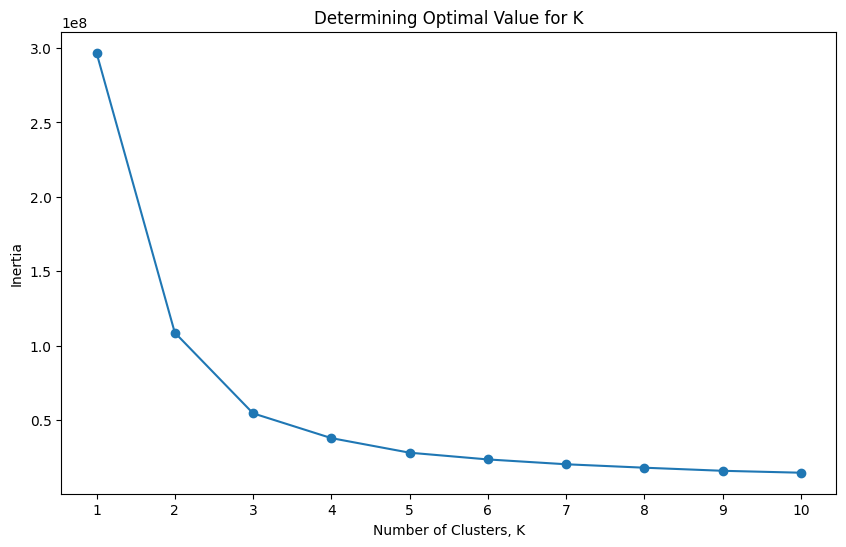

In [8]:
X = audio_features_by_genre_df.loc[:, audio_feature_columns]
inertia_values = []

for k in range(min_clusters, max_clusters):
    
    status = f'Attempting Cluster Size: {k}'
    print(status, end='\r')  # '\r' moves the cursor to the beginning of the same line, effectively overwriting previous line
    
    kmeans_main_model = KMeans(n_clusters=k, random_state=42)
    kmeans_main_model.fit(X)
    inertia_values.append(kmeans_main_model.inertia_)

clear_output(wait=True)

plt.figure(figsize=(10, 6))
plt.plot(range(min_clusters, max_clusters), inertia_values, marker='o')
plt.title('Determining Optimal Value for K')
plt.xlabel('Number of Clusters, K')
plt.ylabel('Inertia')
plt.xticks(range(min_clusters, max_clusters))
plt.show()

In [20]:
audio_features_kmeans_df = audio_features_by_genre_df.copy()

X = audio_features_kmeans_df.loc[:, audio_feature_columns]

num_clusters = 6
kmeans_main_model = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_main_model.fit(X)

model_file_path = '../models/cluster_kmeans_model.joblib'
joblib.dump(kmeans_main_model, model_file_path)

print(f'KMeans model saved to {model_file_path}')

KMeans model saved to ../models/cluster_kmeans_model.joblib


In [10]:
model_file_path = '../models/modlkmeans_model.joblib'
kmeans_main_model = joblib.load(model_file_path)

status = f'Kmeans Model succesfully loaded'
print(status, end='\r')

audio_features_kmeans_df['cluster'] = kmeans_main_model.labels_ + 1
audio_features_kmeans_df.sort_values(by='cluster', inplace=True)

selected_columns = ['genre', 'cluster', 'track_name', 'track_uri']
selected_df = audio_features_kmeans_df[selected_columns]
clustered_audio_features_by_genre_file_path = '../../data/processed_data/genres/clustered_audio_features_by_genre.csv'
selected_df.to_csv(clustered_audio_features_by_genre_file_path, index=False)

print(f'Sorted and selected data with cluster assignments written to {clustered_audio_features_by_genre_file_path}')

Sorted and selected data with cluster assignments written to ../../data/processed_data/genres/clustered_audio_features_by_genre.csv


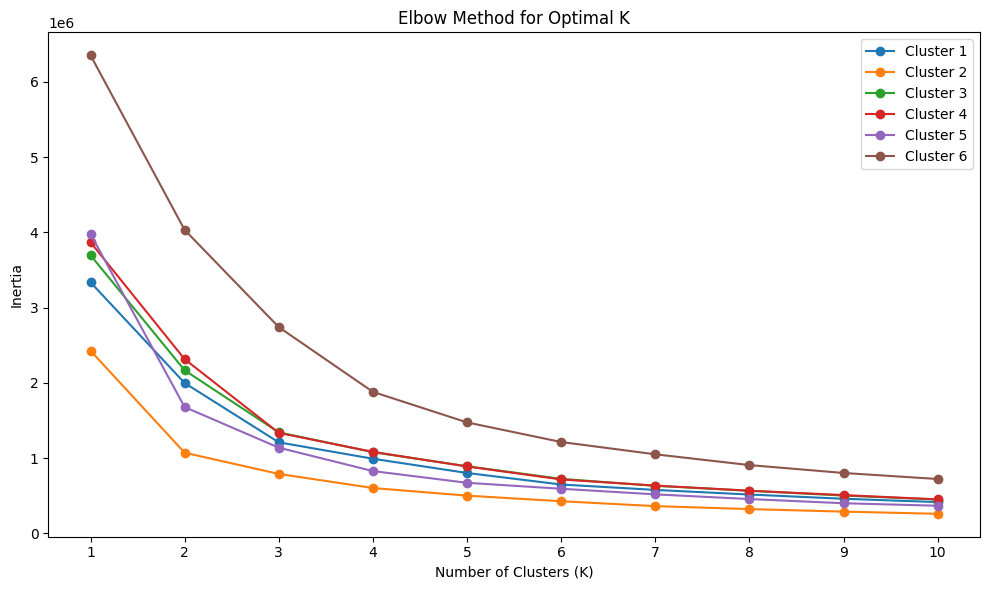

In [11]:
unique_clusters = audio_features_kmeans_df['cluster'].unique()

plt.figure(figsize=(10, 6))

for cluster in unique_clusters:
    status = f'Finding optimal value of K for Cluster {cluster}'
    print(status)
    
    # Filter data for the current cluster
    cluster_data = audio_features_kmeans_df[audio_features_kmeans_df['cluster'] == cluster]
    X = cluster_data.loc[:, audio_feature_columns]

    # Perform the elbow method to find the optimal K value
    inertia_values = []
    
    for k in range(min_clusters, max_clusters):
        status = f'Attempting Cluster Size: {k}'
        print(status, end='\r')
        
        kmeans_subcluster_model = KMeans(n_clusters=k, random_state=42)
        kmeans_subcluster_model.fit(X)
        inertia_values.append(kmeans_subcluster_model.inertia_)

    clear_output(wait=True)
    
    # Plot the elbow method results for each cluster on the same chart
    plt.plot(range(min_clusters, max_clusters), inertia_values, marker='o', label=f'Cluster {cluster}')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.xticks(range(min_clusters, max_clusters))
    plt.legend()

plt.tight_layout()
plt.show()

In [12]:
num_subclusters_per_cluster = {
    1: 6,
    2: 5,
    3: 6,
    4: 6,
    5: 5,
    6: 5
}

for cluster, num_subclusters in num_subclusters_per_cluster.items():
    status = f'Building Subcluster Model for Cluster {cluster}'
    print(status, end='\r')
    
    cluster_data = audio_features_kmeans_df[audio_features_kmeans_df['cluster'] == cluster]

    X_subcluster = cluster_data.loc[:, audio_feature_columns]

    kmeans_subcluster_model = KMeans(n_clusters=num_subclusters, random_state=42)
    kmeans_subcluster_model.fit(X_subcluster)

    # Save the subcluster KMeans model
    subcluster_model_file_path = f'../models/subcluster_kmeans_model_cluster_{cluster}.joblib'
    joblib.dump(kmeans_subcluster_model, subcluster_model_file_path)

print("All subclustering models successfully built and saved.")

All subclustering models successfully built and saved.


In [13]:
subcluster_models = {}

# Loading subcluster models into subcluster_models
for cluster in num_subclusters_per_cluster.keys():
    subcluster_model_file_path = f'../models/subcluster_kmeans_model_cluster_{cluster}.joblib'
    loaded_subcluster_model = joblib.load(subcluster_model_file_path)
    subcluster_models[cluster] = loaded_subcluster_model
    
status = f'All Subcluster Models succesfully loaded'
print(status, end='\r')

# Assigning subcluster labels to data
for cluster, kmeans_subcluster_model in subcluster_models.items():
    status = f'Processing Subclustering for Cluster {cluster}'
    print(status, end='\r')
    
    cluster_data = audio_features_kmeans_df[audio_features_kmeans_df['cluster'] == cluster]
    X_subcluster = cluster_data.loc[:, audio_feature_columns]
    subcluster_labels = kmeans_subcluster_model.predict(X_subcluster)
    audio_features_kmeans_df.loc[audio_features_kmeans_df['cluster'] == cluster, 'subcluster'] = subcluster_labels.astype(int) + 1

audio_features_kmeans_df.sort_values(by=['cluster', 'subcluster'], inplace=True)

selected_columns = ['genre', 'cluster', 'subcluster', 'track_name', 'track_uri']
clustered_audio_features_by_genre_file_path = '../../data/processed_data/genres/clustered_audio_features_by_genre.csv'
audio_features_kmeans_df[selected_columns].to_csv(clustered_audio_features_by_genre_file_path, index=False)

print("All subclustering processes completed.")

All subclustering processes completed.ed


In [26]:
audio_features_kmeans_df = pd.read_csv(clustered_audio_features_by_genre_file_path)

# Convert cluster and subcluster columns to integers and then combine them as strings
audio_features_kmeans_df['genre_cluster'] = (
    audio_features_kmeans_df['cluster'].astype(int).astype(str) +
    ', ' +
    audio_features_kmeans_df['subcluster'].astype(int).astype(str)
)

audio_features_kmeans_df.to_csv(clustered_audio_features_by_genre_file_path, index=False)

print("Added 'genre_cluster' column and saved to CSV.")

Added 'genre_cluster' column and saved to CSV.


### Breakdown of Cluster Details

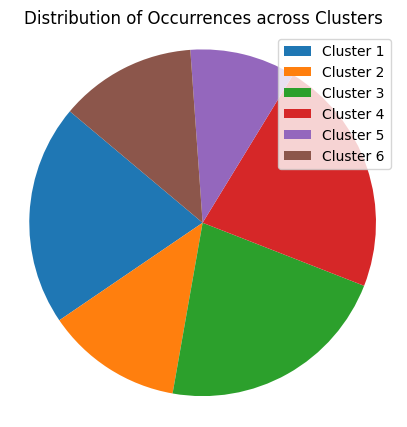

Cluster 1: 64689 occurrences (20.62%)
Cluster 2: 39891 occurrences (12.72%)
Cluster 3: 68539 occurrences (21.85%)
Cluster 4: 69618 occurrences (22.19%)
Cluster 5: 30942 occurrences (9.86%)
Cluster 6: 40017 occurrences (12.76%)


In [27]:
cluster_counts = audio_features_kmeans_df['cluster'].value_counts().sort_index()
sizes = cluster_counts.values

plt.figure(figsize=(5, 5))
plt.pie(sizes, autopct='', startangle=140)
plt.axis('equal')

plt.title("Distribution of Occurrences across Clusters")
plt.legend(labels=[f"Cluster {cluster}" for cluster in cluster_counts.index], loc="best")
plt.show()

total_occurrences = len(audio_features_kmeans_df)

cluster_counts = audio_features_kmeans_df['cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    percentage = (count / total_occurrences) * 100
    print(f"Cluster {cluster}: {count} occurrences ({percentage:.2f}%)")

### Breakdown of Sub-cluster Details

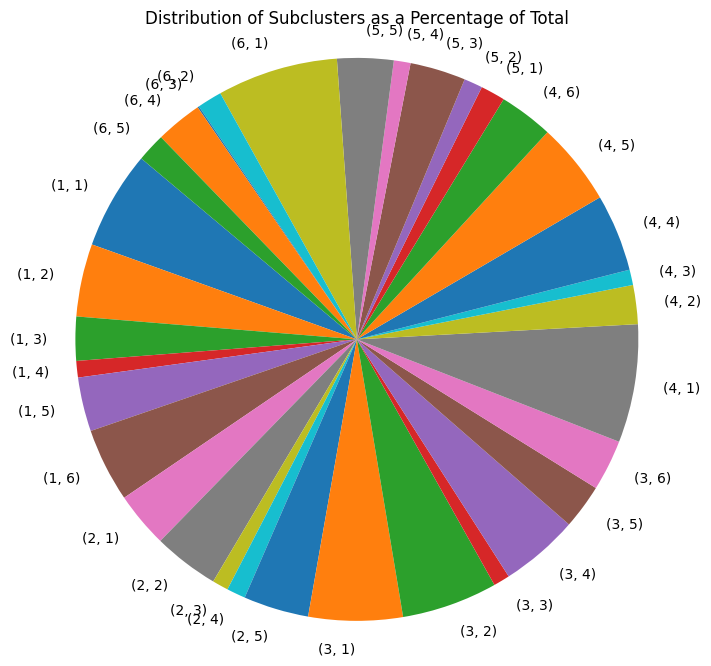

Subclusters for Cluster 1:
  Subcluster 1.0: 17680 occurrences (5.64%)
  Subcluster 2.0: 13100 occurrences (4.18%)
  Subcluster 3.0: 7910 occurrences (2.52%)
  Subcluster 4.0: 2973 occurrences (0.95%)
  Subcluster 5.0: 9739 occurrences (3.10%)
  Subcluster 6.0: 13287 occurrences (4.24%)
Subclusters for Cluster 2:
  Subcluster 1.0: 10005 occurrences (3.19%)
  Subcluster 2.0: 11842 occurrences (3.77%)
  Subcluster 3.0: 2897 occurrences (0.92%)
  Subcluster 4.0: 3386 occurrences (1.08%)
  Subcluster 5.0: 11761 occurrences (3.75%)
Subclusters for Cluster 3:
  Subcluster 1.0: 16948 occurrences (5.40%)
  Subcluster 2.0: 17251 occurrences (5.50%)
  Subcluster 3.0: 2941 occurrences (0.94%)
  Subcluster 4.0: 14167 occurrences (4.52%)
  Subcluster 5.0: 8039 occurrences (2.56%)
  Subcluster 6.0: 9193 occurrences (2.93%)
Subclusters for Cluster 4:
  Subcluster 1.0: 21286 occurrences (6.79%)
  Subcluster 2.0: 7023 occurrences (2.24%)
  Subcluster 3.0: 2771 occurrences (0.88%)
  Subcluster 4.0: 1390

In [28]:
subcluster_counts = audio_features_kmeans_df['genre_cluster'].value_counts().sort_index()
total_subcluster_occurrences = len(audio_features_kmeans_df)
subcluster_percentages = (subcluster_counts / total_subcluster_occurrences) * 100

# Create a pie chart for subcluster distribution
subcluster_labels = [f"({subcluster})" for subcluster in subcluster_counts.index]
subcluster_sizes = subcluster_percentages.values

plt.figure(figsize=(8, 8))  # Adjust the figure size if needed

# Use the labeldistance parameter to control the label positions
plt.pie(subcluster_sizes, labels=subcluster_labels, autopct='', startangle=140, labeldistance=1.1)
plt.axis('equal')

plt.title("Distribution of Subclusters as a Percentage of Total")
plt.show()

# Subcluster breakdown within each cluster
for cluster in cluster_counts.index:
    cluster_data = audio_features_kmeans_df[audio_features_kmeans_df['cluster'] == cluster]
    subcluster_counts = cluster_data['subcluster'].value_counts().sort_index()
    print(f"Subclusters for Cluster {cluster}:")
    for subcluster, subcount in subcluster_counts.items():
        subpercentage = (subcount / total_subcluster_occurrences) * 100
        print(f"  Subcluster {subcluster}: {subcount} occurrences ({subpercentage:.2f}%)")

#### Most Common Genre in each Cluster/Subcluster

In [33]:
cluster_top_genres = audio_features_kmeans_df.groupby('cluster')['genre'].apply(lambda x: Counter(x).most_common(5))

print('Top 5 Genres for each cluster:')
for cluster, top_genres in cluster_top_genres.items():
    print(f"Cluster {cluster}: {', '.join([genre for genre, _ in top_genres])}")

Top 5 Genres for each cluster:
Cluster 1: amapiano, sgija, south african deep house, focus trance, south african soulful deep house
Cluster 2: deep hardtechno, xtra raw, deep full on, hard industrial techno, rawstyle
Cluster 3: nigerian hip hop, golden age hip hop, dancehall, g funk, westcoast flow
Cluster 4: german dark minimal techno, cosmic uplifting trance, psybreaks, uplifting trance, tech trance
Cluster 5: freeform hardcore, darkstep, austrian dnb, russian dnb, neurofunk
Cluster 6: swedish contemporary classical, baltic classical, deep ambient, marcha funebre, post-romantic era


In [39]:
cluster_subgroup_genre_counts = audio_features_kmeans_df.groupby(['genre_cluster'])['genre'].apply(lambda x: [genre for genre, count in Counter(x).most_common(5)])

print('Top 5 Genres for each sub-cluster:')
for (genre_cluster), top_genres in cluster_subgroup_genre_counts.items():
    top_genres_str = ", ".join(top_genres)
    print(f"Subcluster ({genre_cluster.replace(' ', '')}) : {top_genres_str}")

Top 5 Genres for each sub-cluster:
Subcluster (1,1) : pop house, jackin' house, funky house, trap triste, electronica venezuela
Subcluster (1,2) : ohangla, afrobeat, afrobeats, nigerian pop, deep underground hip hop
Subcluster (1,3) : sgija, amapiano, underground amapiano, sotalaulut, georgian electronic
Subcluster (1,4) : italian classical guitar, spanish baroque, background music, sundanese traditional, subliminal product
Subcluster (1,5) : dub techno, ambient dub techno, focus trance, israeli techno, rominimal
Subcluster (1,6) : rap canario, norteno-sax, south african deep house, deep euro house, trap soul
Subcluster (2,1) : xtra raw, bouyon, gym hardstyle, chicago rap, modern jungle
Subcluster (2,2) : full on groove, deep full on, forest psy, full on, goa psytrance
Subcluster (2,3) : bouyon, tin pan alley, makina, nightcore, chinese bgm
Subcluster (2,4) : classical piano duo, dutch contemporary classical, college marching band, new age piano, slovenske chvaly
Subcluster (2,5) : cla

### Cluster/Subcluster Prediction Time

In [55]:
model_file_path = '../models/cluster_kmeans_model.joblib'
kmeans_main_model = joblib.load(model_file_path)

status = f'Kmeans Model succesfully loaded'
print(status, end='\r')

subcluster_models = {}

num_subclusters_per_cluster = {
    1: 6,
    2: 5,
    3: 6,
    4: 6,
    5: 5,
    6: 5
}

# Loading subcluster models into subcluster_models
for cluster in num_subclusters_per_cluster.keys():
    subcluster_model_file_path = f'../models/subcluster_kmeans_model_cluster_{cluster}.joblib'
    loaded_subcluster_model = joblib.load(subcluster_model_file_path)
    subcluster_models[cluster] = loaded_subcluster_model
    
status = f'All Subcluster Models succesfully loaded'
print(status, end='\r')

In [57]:
# sample_track = [{'id': '3Qaw8WaLG0iPXfwVS4cQ11', 'danceability': 0.311, 'energy': 0.311, 'key': 5, 'loudness': -11.516, 'speechiness': 0.0323, 'acousticness': 0.69, 'instrumentalness': 0, 'liveness': 0.195, 'valence': 0.369, 'tempo': 76.951, 'duration_ms': 239507}]

# audio_features = sample_track[0]
# sample_track_audio_features = [
#     audio_features['danceability'],
#     audio_features['energy'],
#     audio_features['loudness'],
#     audio_features['speechiness'],
#     audio_features['acousticness'],
#     audio_features['liveness'],
#     audio_features['valence'],
#     audio_features['tempo'],
# ]
sample_track_audio_features = [0.4663, 0.8475, -4.8202, 0.0864, 0.0602, 0.2457, 0.3269, 147.0671]

# Reshape the audio feature vector to match the input format
sample_track_audio_features = [sample_track_audio_features]

# Predict the cluster and subcluster for the sample track's audio features
predicted_cluster = kmeans_main_model.predict(sample_track_audio_features) + 1
kmeans_subcluster_model = subcluster_models[predicted_cluster[0]]
predicted_subcluster = kmeans_subcluster_model.predict(sample_track_audio_features) + 1  # Use the appropriate subcluster model

print(f"Sample track belongs to Cluster {predicted_cluster[0]}, Subcluster {predicted_subcluster[0]}")

Sample track belongs to Cluster 2, Subcluster 2


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [ ]:
# clustered_audio_features_by_genre_df = pd.read_csv(clustered_audio_features_by_genre_file_path)

# clustered_audio_features_by_genre_df.columns